#### forest fire
elliptical kernel for fire spread

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def _create_rotated_distribution(mean, cov_matrix, rot_matrix):    
    # Rotate the covariance matrix
    rotated_cov_matrix = np.dot(rot_matrix,
                                np.dot(cov_matrix, rot_matrix.T))
    
    # Create a multivariate normal distribution with the rotated covariance matrix
    rotated_distribution = scipy.stats.multivariate_normal(mean=mean,
                                                           cov=rotated_cov_matrix)
    
    return rotated_distribution

def create_kernel(kernel_size, major_axis, minor_axis, center=(0, 0), angle_deg = 35):
    if major_axis < minor_axis:
        major_axis, minor_axis = minor_axis, major_axis
        print('flipped axes (something went wrong!)')
    # process angle
    angle_rad = np.deg2rad(angle_deg)
        
    # define the covariance matrix
    cov_matrix = np.array([[major_axis**2, 0], [0, minor_axis**2]])
    
    # find foci
    c = np.sqrt(major_axis**2 - minor_axis**2)
    focus = [c,0]
    
    # define the rotation matrix 
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])
    
    # rotate the foci and covariance matrix
    rotated_focus = np.dot(rotation_matrix,focus)
    rotated_distribution = _create_rotated_distribution(mean = rotated_focus,
                                                       cov_matrix = cov_matrix,
                                                       rot_matrix = rotation_matrix)
    
    # sample from the rotated distribution at kernel positions
    x, y = np.meshgrid(np.linspace(-2, 2, kernel_size),
                       np.linspace(-2, 2, kernel_size))
    pos = np.dstack((x, y))
    ellipse = rotated_distribution.pdf(pos)
    
    # Normalize the ellipse
    ellipse /= np.max(ellipse)
        
    return ellipse
    

In [3]:
''' development '''
# ---- main inputs ----
# wind components: values between -1 and 1 make sense here
windx = 1
windy = 0.5

# intensity: scales the convolution afterward. values between 0 and 1.
intensity = 0.3
# kernel size: make this large to see a high resolution ellipse.
size = 9



# ---- derived values ----
total_wind = np.sqrt(windx**2 + windy**2)
wind_angle = np.rad2deg(np.arctan2(windy, windx))
print(f'{total_wind = }')
print(f'{wind_angle = } (degrees)')

# major and minor axes are lines with intercept based on intensity
# (these parameters will need tuning)
# intercept
_intensity_bonus = intensity * 0.5
_basic_axis = 0.2 + _intensity_bonus
# slopes increase axes proportional to total wind
_major_slope = 0.3
_minor_slope = 0.1
major_axis = _basic_axis + _major_slope * total_wind
minor_axis = _basic_axis + _minor_slope * total_wind

# ---- create kernel ---- 
kernel = create_kernel(size,
                       major_axis,
                       minor_axis,
                       angle_deg = wind_angle) * intensity


total_wind = 1.118033988749895
wind_angle = 26.56505117707799 (degrees)


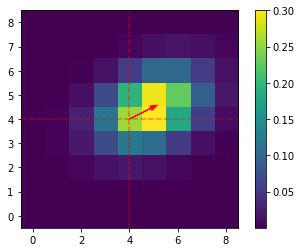

In [4]:
# ---- visualize kernel ---- 
plt.imshow(kernel,origin='lower')
# indicate center
plt.axvline(size//2,c='r',ls='--',alpha=0.4)
plt.axhline(size//2,c='r',ls='--',alpha=0.4)
# indicate wind direction
plt.arrow(x = size//2,
          y = size//2,
          dx = np.cos(np.deg2rad(wind_angle)),
          dy = np.sin(np.deg2rad(wind_angle)),
          head_width = 0.2,
          color='r')
plt.colorbar();


In [10]:

def complete_process(windx, windy, intensity, kernel_size = 9):
    # ---- derived values ----
    total_wind = np.sqrt(windx**2 + windy**2)
    wind_angle = np.rad2deg(np.arctan2(windy, windx))

    # lines
    _intensity_bonus = intensity * 0.5
    _basic_axis = 0.2 + _intensity_bonus
    # slopes increase axes proportional to total wind
    _major_slope = 0.3
    _minor_slope = 0.1
    major_axis = _basic_axis + _major_slope * total_wind
    minor_axis = _basic_axis + _minor_slope * total_wind

    # ---- create kernel ---- 
    return create_kernel(size, major_axis, minor_axis, angle_deg = wind_angle) * intensity


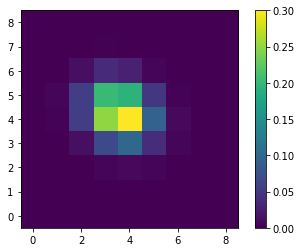

In [14]:
# ---- quickly make and visualize ----
plt.imshow(complete_process(windx = -0.3, # -1 to 1
                            windy = 0.2,  # -1 to 1
                            intensity = 0.3),
          origin='lower')
plt.colorbar()


problem: the kernel incorporates intensity, so convolutions are not simple.

if intensities are discretized, you can make one kernel per intensity level and convolve. this would result in N convolved maps, which can be summed down to a single one.